In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import copy
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import json
import os

In [ ]:
!pip install  scikit-allel

     |████████████████████████████████| 5.7 MB 7.0 MB/s 


In [ ]:
!pip install pyBigWig

     |████████████████████████████████| 64 kB 3.1 MB/s 
  Created wheel for pyBigWig: filename=pyBigWig-0.3.18-cp37-cp37m-linux_x86_64.whl size=193961 sha256=5fe94b03359658637840876455e3c6ce94b4486649e2488ad1d8d67e05f1d793
  Stored in directory: /root/.cache/pip/wheels/28/eb/46/c761563ba38bd516bcc6accde3d4188cd84eec067f9201cbec
Successfully built pyBigWig


In [ ]:

import allel
import pyBigWig
from google.colab import drive
drive.mount('/content/drive/')

parent_dir_name = 'CS194-172 Final Project'

for dirpath, subdirs, files in os.walk('/content/'):
  if parent_dir_name in subdirs:
    parent_path = dirpath + "/" + parent_dir_name

parent_path

Mounted at /content/drive/


'/content/drive/MyDrive/CS 194-172/CS194-172 Final Project'

In [ ]:
missense = allel.vcf_to_dataframe(parent_path + '/clinvar_missense.vcf', fields='*', alt_number=1)

/usr/local/lib/python3.7/dist-packages/allel/io/vcf_read.py:1736: UserWarning: multiple INFO headers for 'GENEINFO'
  warnings.warn('multiple INFO headers for %r' % k)


In [ ]:
missense

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp
0,1,925952,1019397,G,A,NaN,NaN,NaN,NaN,1003021,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.925952G>A,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
1,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
2,1,930188,846933,G,A,NaN,NaN,NaN,NaN,824438,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930188G>A,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
3,1,930200,1043045,G,A,NaN,NaN,NaN,NaN,1023510,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930200G>A,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
4,1,930203,972363,C,T,NaN,NaN,NaN,NaN,959431,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930203C>T,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26091,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY:6736,SO:0001583|missense_variant,1,1556370576,-1,False,1,0,True
26092,Y,2787551,9754,C,T,NaN,NaN,0.00009,NaN,24793,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787551C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0021|UniProtKB_(pr...,NaN,SRY:6736,SO:0001583|missense_variant,1,104894971,-1,False,1,0,True
26093,Y,7063898,625467,A,T,NaN,0.00123,0.00048,NaN,613772,Deafness,NaN,MONDO:MONDO:0027048,NaN,NC_000024.10:g.7063898A>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:400033.0001,NaN,TBL1Y:90665,SO:0001583|missense_variant,1,199659121,-1,False,1,0,True
26094,Y,14622379,559565,G,A,NaN,NaN,NaN,NaN,550288,not_provided,NaN,MedGen:CN517202,NaN,NC_000024.10:g.14622379G>A,criteria_provided,Uncertain_significance,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,NLGN4Y:22829,SO:0001583|missense_variant,32,1556057385,-1,False,1,0,True


In [ ]:
#Keep pathogenic and benign variants only, assign class label of 1 to pathogenic and 0 to benign
missense = missense[(missense['CLNSIG'] == 'Pathogenic') | (missense['CLNSIG'] == 'Benign')]
missense['Class label']= np.where(missense['CLNSIG']=='Pathogenic', 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
missense

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,Class label
1,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
5,1,930204,1170208,G,A,NaN,NaN,NaN,NaN,1153702,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930204G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
10,1,930285,1165489,G,A,NaN,NaN,NaN,NaN,1153703,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930285G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
11,1,930314,1170010,C,T,NaN,NaN,NaN,NaN,1153704,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930314C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
20,1,935779,1167937,G,A,NaN,NaN,NaN,NaN,1153708,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935779G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11:148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26089,Y,2787412,9747,C,T,NaN,NaN,NaN,NaN,24786,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787412C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,UniProtKB_(protein):Q05066#VAR_003721|OMIM_All...,NaN,SRY:6736,SO:0001583|missense_variant,1,104894969,-1,False,1,0,True,1
26090,Y,2787426,9739,C,G,NaN,NaN,NaN,NaN,24778,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787426C>G,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0004|UniProtKB_(pr...,NaN,SRY:6736,SO:0001583|missense_variant,1,104894957,-1,False,1,0,True,1
26091,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY:6736,SO:0001583|missense_variant,1,1556370576,-1,False,1,0,True,1
26092,Y,2787551,9754,C,T,NaN,NaN,0.00009,NaN,24793,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787551C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0021|UniProtKB_(pr...,NaN,SRY:6736,SO:0001583|missense_variant,1,104894971,-1,False,1,0,True,1


**Part 1: Features Selection** 
- RVIS Score
-PhastCons Value 
-O/E Value 
-Exac_pLI Value 
-Xpresso
-GDI Index
-CAAD: [CADD_score, Grantham, PolyPhenVal ,SIFTval]

**RVIS Score**



In [ ]:
#Read data set and drop unnecessary columns 
rvis_data = pd.read_csv(parent_path + '/RVIS_Unpublished_ExACv2_March2017.txt', delimiter="\t")
rvis_data = rvis_data.drop(columns=['%geneCov', 'RVIS[pop_maf_0.05%(any)]', 'Edge_case_RVIS[pop_maf_0.05%(any)]', 'OE-ratio_[ExAC v2]', 'alternative-RVIS[maf_0.0025%]', 'alternative-%RVIS[maf_0.0025%]', '%OE-ratio_[ExAC v2]'])
rvis_data = rvis_data.set_index("CCDSr20")

#Clean up GENEINFO column to merge rviz values 
missense['GENEINFO'] = missense['GENEINFO'].str.replace(':', ' ')
missense['GENEINFO'] = missense['GENEINFO'].str.replace('|', ' ')
missense[['GENE1', 'NUM1', 'GENE2', 'NUM2']] =  missense['GENEINFO'].str.split(' ', 3, expand=True)

missense = pd.merge(missense, rvis_data, left_on="GENE1", right_on="CCDSr20", how="left")
missense['%RVIS[pop_maf_0.05%(any)]'] = missense['%RVIS[pop_maf_0.05%(any)]'].replace(np.nan, 50)
missense= missense.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "first rvis"})
missense = pd.merge(missense, rvis_data, left_on="GENE2", right_on="CCDSr20", how="left")
missense= missense.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "second rvis"})
missense["second rvis"] = missense[missense['GENE2'].values != None]["second rvis"].replace(np.nan, 50)

#Take average of gene1 and gene2 rvis values 
missense["mean RVIS score"] =  missense[["first rvis", "second rvis"]].mean(axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'RVIS')

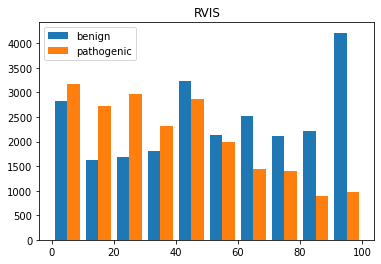

In [ ]:
#plot histogram 
pathogenic = missense[missense['Class label']== 1]
benign = missense[missense['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['mean RVIS score'], pathogenic['mean RVIS score']], label=names)
plt.legend()
plt.title("RVIS")

**PhastCons Value**

In [ ]:
#Extract phastCons data and append it to variants
phastcons_data = pyBigWig.open(parent_path + "/hg38.phastCons100way.bw")
missense["phastCons"] = [phastcons_data.stats("chr" + x, y, y+1) for x, y in zip(missense["CHROM"],missense["POS"])]
missense["phastCons"] = missense["phastCons"].str[0]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'PhastCons')

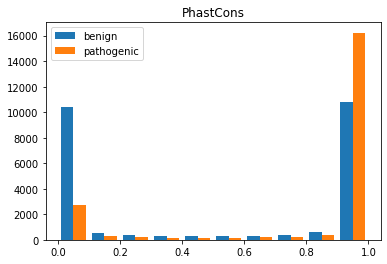

In [ ]:
#Plot a histogram
pathogenic = missense[missense['Class label']== 1]
benign = missense[missense['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['phastCons'], pathogenic['phastCons']], label=names)
plt.legend()
plt.title("PhastCons")

**O/E Value and 
Exac_pLI Value**

In [ ]:
#Extract gnomad data and append values to variants
gnomad_data = pd.read_csv(parent_path + '/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz', compression='gzip', sep='\t', quotechar='"')
gnomad_data = gnomad_data.loc[:, gnomad_data.columns.intersection(['gene','oe_lof_upper_rank', 'exac_pLI'])]
missense = pd.merge(missense, gnomad_data, left_on="GENE1", right_on="gene", how="left")
missense["oe_lof_upper_rank"] = missense["oe_lof_upper_rank"].replace(np.nan, missense["oe_lof_upper_rank"].max()/2)
missense["exac_pLI"] = missense["exac_pLI"].replace(np.nan, missense["exac_pLI"].max()/2)
missense= missense.rename(columns={'oe_lof_upper_rank': "first oe_lof_upper_rank"})
missense= missense.rename(columns={'exac_pLI': "first exac_pLI"})


In [ ]:
missense = pd.merge(missense, gnomad_data, left_on="GENE2", right_on="gene", how="left")
missense["oe_lof_upper_rank"] = missense[missense['GENE2'].values != None]["oe_lof_upper_rank"].replace(np.nan, missense["oe_lof_upper_rank"].max()/2)
missense["exac_pLI"] = missense[missense['GENE2'].values != None]["exac_pLI"].replace(np.nan, missense["exac_pLI"].max()/2)
missense= missense.rename(columns={'oe_lof_upper_rank': "second oe_lof_upper_rank"})
missense= missense.rename(columns={'exac_pLI': "second exac_pLI"})
missense["oe_lof_upper_rank"] =  missense[["first oe_lof_upper_rank", "second oe_lof_upper_rank" ]].mean(axis=1)
missense["exac_pLI"] =  missense[["first exac_pLI", "second exac_pLI"]].mean(axis=1)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'O/E')

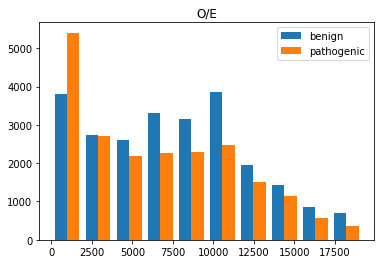

In [ ]:
#Plot histograms
pathogenic = missense[missense['Class label']== 1]
benign = missense[missense['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['oe_lof_upper_rank'], pathogenic['oe_lof_upper_rank']], label=names)
plt.legend()
plt.title("O/E")


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'exac_pLI')

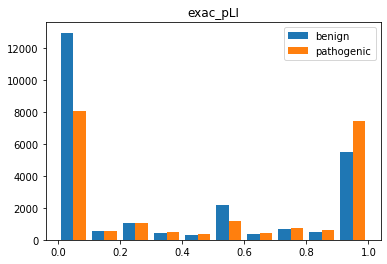

In [ ]:
#Plot histograms
pathogenic = missense[missense['Class label']== 1]
benign = missense[missense['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign["exac_pLI"], pathogenic["exac_pLI"]], label=names)
plt.legend()
plt.title("exac_pLI")

**Gene Expression Level**

In [ ]:
# from Xpresso dataset
# read by default 1st sheet of an excel file
dataframe1 = pd.read_excel(parent_path + "/xpresso.xlsx")
Xpresso = dataframe1[['Unnamed: 1', 'Unnamed: 63']][2:]
Xpresso = Xpresso.rename(columns={'Unnamed: 1':"Gene Name", 'Unnamed: 63':"Median expression" })[1:]
missense = pd.merge(missense, Xpresso, left_on="GENE1", right_on="Gene Name", how="left")
missense["Median expression"] = missense["Median expression"].replace(np.nan, 0)
missense = missense.rename(columns = {"Median expression": "median_expression_level_1"})

missense = pd.merge(missense, Xpresso, left_on="GENE2", right_on="Gene Name", how="left")
missense["Median expression"] = missense[missense['GENE2'].values != None]["Median expression"].replace(np.nan, 0)
missense = missense.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
missense["mean gene_expression_level"] =  missense[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
missense = missense.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])


In [ ]:
missense

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,first oe_lof_upper_rank,first exac_pLI,gene_y,second oe_lof_upper_rank,second exac_pLI,oe_lof_upper_rank,exac_pLI,mean gene_expression_level
0,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.437,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206
1,1,930204,1170208,G,A,NaN,NaN,NaN,NaN,1153702,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930204G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.978,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206
2,1,930285,1165489,G,A,NaN,NaN,NaN,NaN,1153703,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930285G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.168,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206
3,1,930314,1170010,C,T,NaN,NaN,NaN,NaN,1153704,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930314C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.006,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206
4,1,935779,1167937,G,A,NaN,NaN,NaN,NaN,1153708,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935779G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,1.000,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45314,Y,2787412,9747,C,T,NaN,NaN,NaN,NaN,24786,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787412C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,UniProtKB_(protein):Q05066#VAR_003721|OMIM_All...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894969,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,1.000,SRY,9597.5,4.160200e-01,NaN,NaN,NaN,9597.5,4.160200e-01,0.000
45315,Y,2787426,9739,C,G,NaN,NaN,NaN,NaN,24778,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787426C>G,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0004|UniProtKB_(pr...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894957,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.997,SRY,9597.5,4.160200e-01,NaN,NaN,NaN,9597.5,4.160200e-01,0.000
45316,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY 6736,SO:0001583|missense_variant,1,1556370576,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.000,SRY,9597.5,4.160200e-01,NaN,NaN,NaN,9597.5,4.160200e-01,0.000
45317,Y,2787551,9754,C,T,NaN,NaN,0.00009,NaN,24793,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787551C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:48000

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


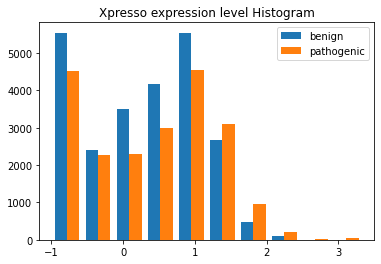

In [ ]:
plt.hist([missense[missense["Class label"] == 0 ]["mean gene_expression_level"],missense[missense["Class label"] == 1 ]["mean gene_expression_level"]], label = ["benign", "pathogenic"])  
plt.title('Xpresso expression level Histogram')


plt.legend(loc='upper right')

**GDI Index**

In [ ]:
import re
gdi_data = pd.read_csv(parent_path + "/GDI_full.txt",  delimiter="\t")
gdi_data = gdi_data[["Gene", "GDI-Phred"]]
gdi_data = gdi_data.rename(columns={"Gene": "Gene Name", "GDI-Phred":"Median expression"})


missense = pd.merge(missense, gdi_data, left_on="GENE1", right_on="Gene Name", how="left")
missense["Median expression"] = missense["Median expression"].replace(np.nan, missense["Median expression"].max()/2)
missense = missense.rename(columns = {"Median expression": "median_expression_level_1"})

missense = pd.merge(missense, gdi_data, left_on="GENE2", right_on="Gene Name", how="left")
missense["Median expression"] = missense[missense['GENE2'].values != None]["Median expression"].replace(np.nan, missense["Median expression"].max()/2)
missense = missense.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
missense["GDI"] =  missense[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
missense = missense.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


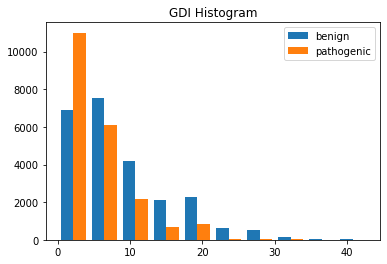

In [ ]:
plt.hist([missense[missense["Class label"] == 0 ]["GDI"],missense[missense["Class label"] == 1 ]["GDI"]], label = ["benign", "pathogenic"])  
plt.title('GDI Histogram')


plt.legend(loc='upper right')

**CADD**

In [ ]:
# https://cadd.gs.washington.edu/score
# 1.6 
# press INCLUDE ANNOTATIONS to also include other values:
# has SIFT, GRANTHAM, POLYPHEN values

# only for SNVs, doesn't accept file format with multiple alt alleles list 
# entire vcf file might be too large (excepts 100k variants, maybe try gzip compressed)

1. Create gzipped vcf file, with proper format and without extra data for speed

In [ ]:
# https://cadd.gs.washington.edu/score
# 1.6 
# press INCLUDE ANNOTATIONS to also include other values:
# has SIFT, GRANTHAM, POLYPHEN values

# only for SNVs, doesn't accept file format with multiple alt alleles list 
# entire vcf file might be too large (excepts 100k variants, maybe try gzip compressed)



new = missense[["CHROM", "POS", "ID", "REF", "ALT"]]
# new = new.iloc[0:20]
new["ALT"] = new["ALT"].apply(lambda row: row[0])
header = """##fileformat=VCFv4.1
#CHROM POS ID REF ALT
"""

output_VCF = "missense_data.vcf"
with open(output_VCF, 'w') as vcf:
    vcf.write(header)

new.to_csv(output_VCF, sep="\t", mode='a', index=False)

# import gzip
# import shutil
# with open('file.txt', 'rb') as f_in:
#     with gzip.open('file.txt.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)


# turn in to # https://cadd.gs.washington.edu/score with ANNOTATIONS selected

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2.Upload to https://cadd.gs.washington.edu/score **with ANNOTATIONS selected**
and cadd model GRCh38-v1.6

---



3. Upload resulting file to folder, below code reads as df

In [ ]:
import gzip
with gzip.open(parent_path +'/38-missense.tsv.gz', 'rt') as f:
  # with gzip.open('chr22_subsampled_snps.vcf.gz', 'rt') as f:
  lines = f.readlines()
  with open('caddunzipped.txt', 'w') as t:
    for line in lines[1:]:
        t.write(line)
        t.write('\n')
cadd_data = pd.read_csv('caddunzipped.txt', delimiter="\t")
cadd_data = cadd_data.rename(columns={"PHRED": "CADD_score"})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,129) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
cadd_data = cadd_data.drop_duplicates(
  subset = ['#Chrom', 'Pos'],
  keep = 'last').reset_index(drop = True)
cadd_data["#Chrom"] = cadd_data["#Chrom"].apply(lambda r:str(r))
  

In [ ]:
cadd_data

,#Chrom,Pos,Ref,Alt,Type,Length,AnnoType,Consequence,ConsScore,ConsDetail,GC,CpG,motifECount,motifEName,motifEHIPos,motifEScoreChng,oAA,nAA,GeneID,FeatureID,GeneName,CCDS,Intron,Exon,cDNApos,relcDNApos,CDSpos,relCDSpos,protPos,relProtPos,Domain,Dst2Splice,Dst2SplType,minDistTSS,minDistTSE,SIFTcat,SIFTval,PolyPhenCat,PolyPhenVal,priPhCons,...,EncodeH3K27me3-max,EncodeH3K36me3-sum,EncodeH3K36me3-max,EncodeH3K79me2-sum,EncodeH3K79me2-max,EncodeH4K20me1-sum,EncodeH4K20me1-max,EncodeH2AFZ-sum,EncodeH2AFZ-max,EncodeDNase-sum,EncodeDNase-max,EncodetotalRNA-sum,EncodetotalRNA-max,Grantham,SpliceAI-acc-gain,SpliceAI-acc-loss,SpliceAI-don-gain,SpliceAI-don-loss,MMSp_acceptorIntron,MMSp_acceptor,MMSp_exon,MMSp_donor,MMSp_donorIntron,Dist2Mutation,Freq100bp,Rare100bp,Sngl100bp,Freq1000bp,Rare1000bp,Sngl1000bp,Freq10000bp,Rare10000bp,Sngl10000bp,EnsembleRegulatoryFeature,dbscSNV-ada_score,dbscSNV-rf_score,RemapOverlapTF,RemapOverlapCL,RawScore,CADD_score
0,1,930165,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.662,0.080,NaN,NaN,NaN,NaN,R,Q,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,166.0,0.065,83.0,0.041,28.0,0.041,hmmpanther,11.0,ACCEPTOR,148,5629,deleterious,0.00,possibly_damaging,0.778,0.939,...,4.68,6.49,1.87,4.46,1.26,10.54,2.04,4.80,1.20,0.62,0.17,0.67,0.30,43.0,0.00,0.0,0.00,0.0,0.0,0.000,0.023,0.0,0.0,6.0,0.0,1.0,19.0,1.0,17.0,196.0,40.0,115.0,1971.0,NaN,NaN,NaN,9.0,11.0,4.225333,28.900
1,1,930204,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.669,0.120,NaN,NaN,NaN,NaN,R,Q,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,205.0,0.080,122.0,0.060,41.0,0.060,hmmpanther,NaN,NaN,109,5590,deleterious,0.01,possibly_damaging,0.886,0.084,...,5.61,6.21,1.62,4.30,1.26,12.99,2.69,5.87,2.01,0.65,0.18,0.68,0.21,43.0,0.00,0.0,0.00,0.0,0.0,0.000,-0.090,0.0,0.0,9.0,0.0,3.0,23.0,1.0,17.0,196.0,40.0,114.0,1972.0,NaN,NaN,NaN,9.0,14.0,2.879554,23.200
2,1,930285,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.623,0.120,NaN,NaN,NaN,NaN,R,Q,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,286.0,0.112,203.0,0.099,68.0,0.100,hmmpanther,NaN,NaN,28,5509,tolerated,0.34,benign,0.001,0.005,...,4.63,9.82,4.72,7.44,2.00,17.17,3.29,10.70,4.03,0.60,0.14,0.49,0.24,43.0,0.00,0.0,0.00,0.0,0.0,0.000,-0.008,0.0,0.0,8.0,0.0,6.0,30.0,1.0,16.0,200.0,42.0,115.0,1982.0,NaN,NaN,NaN,13.0,18.0,0.091394,2.015
3,1,930314,C,T,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.649,0.120,NaN,NaN,NaN,NaN,H,Y,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,315.0,0.123,232.0,0.113,78.0,0.115,hmmpanther,NaN,NaN,2,5480,deleterious,0.04,possibly_damaging,0.637,0.042,...,6.22,8.49,3.96,8.31,3.60,17.78,3.80,11.69,4.03,0.59,0.22,0.75,0.46,83.0,0.00,0.0,0.07,0.0,0.0,-0.204,-0.252,0.0,0.0,2.0,0.0,5.0,30.0,1.0,16.0,206.0,41.0,114.0,1974.0,NaN,NaN,NaN,13.0,18.0,2.481464,22.400
4,1,935779,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.662,0.147,NaN,NaN,NaN,NaN,G,S,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,5/14,396.0,0.155,313.0,0.153,105.0,0.154,hmmpanther,8.0,ACCEPTOR,5467,15,tolerated,1.00,benign,0.000,0.425,...,23.92,7.08,2.14,10.06,5.40,17.69,5.28,15.21,3.26,1.32,0.64,0.91,0.73,56.0,0.13,0.0,0.00,0.0,0.0,0.000,-0.290,0.0,0.0,15.0,0.0,1.0,26.0,2.0,17.0,268.0,30.0,112.0,2032.0,NaN,NaN,NaN,25.0,40.0,1.831757,17.970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43890,Y,2787412,C,T,SNV,0,Intergenic,UPSTREAM,1,upstream,0.490,0.120,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000237659,ENST00000454281,RNASEH2CP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288,557,NaN,NaN,NaN,NaN,0.293,...,5.12,5.55,2.97,1.54,0.64,1.81,0.98,10.06,3.99,0.43,0.31,0.22,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,23.0,2.3510

In [ ]:
cadd_columns = ["CADD_score", "Grantham", "PolyPhenVal" ,"SIFTval"]
cadd_data = cadd_data[["#Chrom", "Pos"]+cadd_columns]
cadd_missense_merged = pd.merge(left = missense, right = cadd_data, left_on = ["CHROM", "POS"], right_on=["#Chrom", "Pos"],how="left")
for col in cadd_columns:
  cadd_missense_merged[col] = cadd_missense_merged[col].replace(np.nan, cadd_missense_merged[col].max()/2) 

In [ ]:
cadd_missense_merged

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,first oe_lof_upper_rank,first exac_pLI,gene_y,second oe_lof_upper_rank,second exac_pLI,oe_lof_upper_rank,exac_pLI,mean gene_expression_level,GDI,#Chrom,Pos,CADD_score,Grantham,PolyPhenVal,SIFTval
0,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.437,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,1,930165,28.900,43.0,0.778,0.00
1,1,930204,1170208,G,A,NaN,NaN,NaN,NaN,1153702,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930204G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.978,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,1,930204,23.200,43.0,0.886,0.01
2,1,930285,1165489,G,A,NaN,NaN,NaN,NaN,1153703,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930285G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.168,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,1,930285,2.015,43.0,0.001,0.34
3,1,930314,1170010,C,T,NaN,NaN,NaN,NaN,1153704,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930314C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.006,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,1,930314,22.400,83.0,0.637,0.04
4,1,935779,1167937,G,A,NaN,NaN,NaN,NaN,1153708,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935779G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,1.000,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,1,935779,17.970,56.0,0.000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45315,Y,2787412,9747,C,T,NaN,NaN,NaN,NaN,24786,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787412C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,UniProtKB_(protein):Q05066#VAR_003721|OMIM_All...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894969,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,1.000,SRY,9597.5,4.160200e-01,NaN,NaN,NaN,9597.5,4.160200e-01,0.000,0.01646,Y,2787412,21.900,107.5,0.500,0.50
45316,Y,2787426,9739,C,G,NaN,NaN,NaN,NaN,24778,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787426C>G,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0004|UniProtKB_(pr...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894957,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.997,SRY,9597.5,4.160200e-01,NaN,NaN,NaN,9597.5,4.160200e-01,0.000,0.01646,Y,2787426,21.000,107.5,0.500,0.50
45317,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY 6736,SO:0001583|missense_variant

In [ ]:
missense = cadd_missense_merged.drop(columns =["#Chrom", "Pos"])


In [ ]:
missense

,CHROM,POS,ID,REF,ALT,QUAL,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,GENEINFO,MC,ORIGIN,RS,SSR,FILTER_PASS,numalt,altlen,is_snp,Class label,GENE1,NUM1,GENE2,NUM2,first rvis,second rvis,mean RVIS score,phastCons,gene_x,first oe_lof_upper_rank,first exac_pLI,gene_y,second oe_lof_upper_rank,second exac_pLI,oe_lof_upper_rank,exac_pLI,mean gene_expression_level,GDI,CADD_score,Grantham,PolyPhenVal,SIFTval
0,1,930165,1164676,G,A,NaN,NaN,NaN,NaN,1153701,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930165G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.437,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,28.900,43.0,0.778,0.00
1,1,930204,1170208,G,A,NaN,NaN,NaN,NaN,1153702,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930204G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.978,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,23.200,43.0,0.886,0.01
2,1,930285,1165489,G,A,NaN,NaN,NaN,NaN,1153703,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930285G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.168,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,2.015,43.0,0.001,0.34
3,1,930314,1170010,C,T,NaN,NaN,NaN,NaN,1153704,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.930314C>T,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,0.006,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,22.400,83.0,0.637,0.04
4,1,935779,1167937,G,A,NaN,NaN,NaN,NaN,1153708,not_provided,NaN,MedGen:CN517202,NaN,NC_000001.11:g.935779G>A,criteria_provided,Benign,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SAMD11 148398,SO:0001583|missense_variant,1,NaN,-1,False,1,0,True,0,SAMD11,148398,None,None,96.686217,NaN,96.686217,1.000,SAMD11,13738.0,1.353800e-10,NaN,NaN,NaN,13738.0,1.353800e-10,0.206,5.65821,17.970,56.0,0.000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45315,Y,2787412,9747,C,T,NaN,NaN,NaN,NaN,24786,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787412C>T,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,UniProtKB_(protein):Q05066#VAR_003721|OMIM_All...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894969,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,1.000,SRY,9597.5,4.160200e-01,NaN,NaN,NaN,9597.5,4.160200e-01,0.000,0.01646,21.900,107.5,0.500,0.50
45316,Y,2787426,9739,C,G,NaN,NaN,NaN,NaN,24778,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787426C>G,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,OMIM_Allelic_Variant:480000.0004|UniProtKB_(pr...,NaN,SRY 6736,SO:0001583|missense_variant,1,104894957,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.997,SRY,9597.5,4.160200e-01,NaN,NaN,NaN,9597.5,4.160200e-01,0.000,0.01646,21.000,107.5,0.500,0.50
45317,Y,2787515,492908,C,A,NaN,NaN,NaN,NaN,485861,46,NaN,MONDO:MONDO:0020712,NaN,NC_000024.10:g.2787515C>A,no_assertion_criteria_provided,Pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,SRY 6736,SO:0001583|missense_variant,1,1556370576,-1,False,1,0,True,1,SRY,6736,None,None,50.000000,NaN,50.000000,0.000,S

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

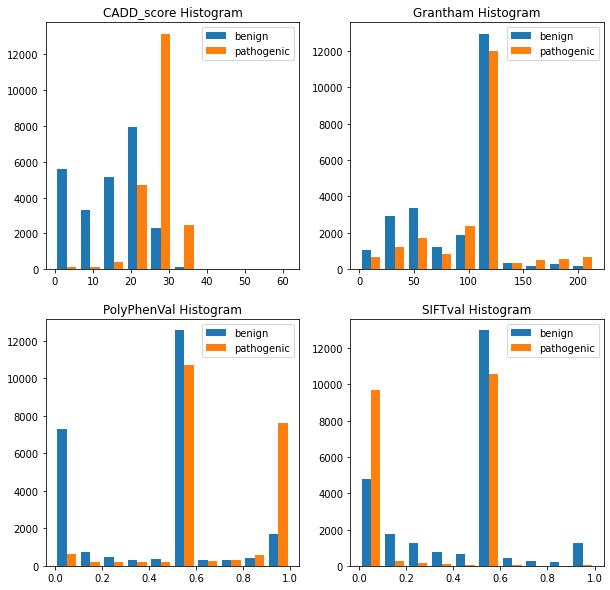

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(2):
    for j in range(2):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(cadd_columns):
            col = cadd_columns[counter]


            ax.hist([missense[missense["Class label"] == 0 ][col],missense[missense["Class label"] == 1 ][col]], label = ["benign", "pathogenic"])  
            ax.set_title(col + " Histogram")
            ax.legend(loc='upper right')

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()


**Model Training**

In [ ]:
missense.columns
c =["CHROM", "POS", "Class label", "mean RVIS score", "phastCons", "oe_lof_upper_rank", "exac_pLI", "GDI", "CADD_score", "Grantham", "PolyPhenVal", "SIFTval"]
for val in c:
  if val not in missense.columns:
    print(val)
missense_data = missense[c]

In [ ]:
training_set, validation_set= train_test_split(missense_data, test_size=0.2)

In [ ]:
training_set

,CHROM,POS,Class label,mean RVIS score,phastCons,oe_lof_upper_rank,exac_pLI,GDI,CADD_score,Grantham,PolyPhenVal,SIFTval
25042,12,13567165,1,1.280547,0.000,37.0,9.999900e-01,1.21856,25.70,125.0,1.000,0.00
24006,11,87067726,0,49.208211,1.000,3463.0,8.799300e-01,4.42951,15.57,107.5,0.500,0.50
38995,20,3228260,1,71.407625,1.000,9973.0,1.367300e-08,4.66743,32.00,107.5,0.500,0.50
5807,2,166054672,1,2.375367,0.955,60.0,1.000000e+00,2.65241,29.70,107.5,0.500,0.50
23042,11,32392019,1,36.432063,1.000,1645.0,5.000000e-01,0.94292,29.90,107.5,0.500,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
3789,1,236482366,1,43.020528,0.888,12438.0,1.035700e-01,2.10085,26.00,107.5,0.500,0.50
22199,11,230474,0,70.860215,0.000,11213.0,2.700500e-05,6.02104,22.70,77.0,0.682,0.03
28135,14,24260593,1,86.832845,0.098,9847.0,5.306500e-07,3.56624,24.50,107.5,0.500,0.50
4692,2,55667007,1,49.452590,1.000,4521.0,9.082700e-01,12.01066,28.00,43.0,0.980,0.01


In [ ]:
validation_set

,CHROM,POS,Class label,mean RVIS score,phastCons,oe_lof_upper_rank,exac_pLI,GDI,CADD_score,Grantham,PolyPhenVal,SIFTval
2424,1,156879276,1,90.654936,1.000,6640.0,4.249000e-04,5.508830,27.00,180.0,0.986,0.00
16170,7,90282895,0,67.184751,0.008,9597.5,5.000000e-01,21.456620,13.47,98.0,0.086,0.05
41488,X,10197969,0,7.836991,1.000,570.0,9.887900e-01,0.472950,17.34,15.0,0.000,0.43
4825,2,73450765,0,26.813294,0.000,9170.0,3.036900e-39,25.059950,14.97,60.0,0.646,0.01
1235,1,47260511,0,52.815249,1.000,3382.0,2.026900e-01,2.617780,25.20,144.0,0.590,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
26240,12,80320508,0,50.000000,1.000,9463.0,3.728200e-31,22.344200,28.20,107.5,0.500,0.50
22875,11,17501084,0,55.122190,0.000,9328.0,2.724400e-12,12.491430,21.10,99.0,0.134,0.22
39071,20,5963328,0,89.286413,1.000,10026.0,1.928900e-10,11.888910,18.87,107.5,0.500,0.50
4378,2,32251431,0,13.118280,0.004,9681.0,4.351200e-08,1.710470,14.93,83.0,0.000,0.21


In [ ]:
X_train = training_set.drop(columns=["Class label", "CHROM", "POS"])
Y_train = training_set.loc[:, training_set.columns.intersection(['Class label'])]
X_test = validation_set.drop(columns=["Class label", "CHROM", "POS"])
Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]

In [ ]:
estimators = [50, 100, 150, 200, 250, 300, 350]
kf =KFold(n_splits=5, shuffle=True, random_state=42)
for count in estimators:
    score = cross_val_score(RandomForestClassifier(n_estimators= count, random_state= 42), X_train, Y_train, cv= kf, scoring= "accuracy")
    print(f'For estimators: {count}')
    print(score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 50
0.882447014745023


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 100
0.8831640963534101


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 150
0.8829434637579328


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 200
0.8837709206170701


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 250
0.883798541053698


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 300
0.8834675902587718


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

For estimators: 350
0.8836054794503875


In [ ]:
model = RandomForestClassifier(n_estimators= 250)

In [ ]:
model.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(n_estimators=250)

In [ ]:

Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]
accuracy_score(model.predict(X_test), Y_test)

0.8822815533980582

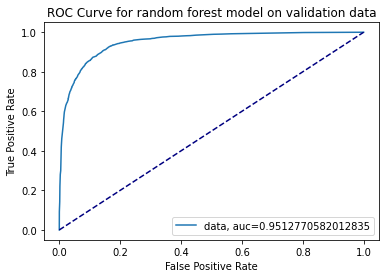

In [ ]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color="navy",linestyle="--")
plt.title("ROC Curve for random forest model on validation data")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

### Likely Benign/ Likely Pathogenic 

In [ ]:
#Likely-benign/ Likely-pathogenic 
missense_likely = allel.vcf_to_dataframe(parent_path + '/clinvar_missense.vcf', fields='*', alt_number=1)
missense_likely['CLNSIG'].unique()

/usr/local/lib/python3.7/dist-packages/allel/io/vcf_read.py:1736: UserWarning: multiple INFO headers for 'GENEINFO'
  warnings.warn('multiple INFO headers for %r' % k)


array(['Uncertain_significance', 'Benign', 'Likely_benign',
       'Likely_pathogenic',
       'Conflicting_interpretations_of_pathogenicity', 'Pathogenic',
       'Benign/Likely_benign', 'Pathogenic/Likely_pathogenic',
       'risk_factor', 'not_provided', nan, 'association', 'drug_response',
       'Affects', 'other', 'protective', 'confers_sensitivity'],
      dtype=object)

In [ ]:
missense_likely = missense_likely[(missense_likely['CLNSIG'] == 'Likely_benign') | (missense_likely['CLNSIG'] == 'Benign/Likely_benign') | (missense_likely['CLNSIG'] == 'Likely_pathogenic') | (missense_likely['CLNSIG'] == 'Pathogenic/Likely_pathogenic') ]
missense_likely['Class label']= np.where((missense_likely['CLNSIG']=='Likely_benign') | (missense_likely['CLNSIG']=='Benign/Likely_benign'), 0, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Step 1: Check if features are good

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'RVIS')

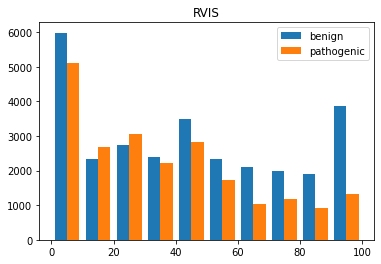

In [ ]:
#Read data set and drop unnecessary columns 
rvis_data = pd.read_csv(parent_path + '/RVIS_Unpublished_ExACv2_March2017.txt', delimiter="\t")
rvis_data = rvis_data.drop(columns=['%geneCov', 'RVIS[pop_maf_0.05%(any)]', 'Edge_case_RVIS[pop_maf_0.05%(any)]', 'OE-ratio_[ExAC v2]', 'alternative-RVIS[maf_0.0025%]', 'alternative-%RVIS[maf_0.0025%]', '%OE-ratio_[ExAC v2]'])
rvis_data = rvis_data.set_index("CCDSr20")

#Clean up GENEINFO column to merge rviz values 
missense_likely['GENEINFO'] = missense_likely['GENEINFO'].str.replace(':', ' ')
missense_likely['GENEINFO'] = missense_likely['GENEINFO'].str.replace('|', ' ')
missense_likely[['GENE1', 'NUM1', 'GENE2', 'NUM2']] =  missense_likely['GENEINFO'].str.split(' ', 3, expand=True)

missense_likely = pd.merge(missense_likely, rvis_data, left_on="GENE1", right_on="CCDSr20", how="left")
missense_likely['%RVIS[pop_maf_0.05%(any)]'] = missense_likely['%RVIS[pop_maf_0.05%(any)]'].replace(np.nan, 50)
missense_likely= missense_likely.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "first rvis"})
missense_likely = pd.merge(missense_likely, rvis_data, left_on="GENE2", right_on="CCDSr20", how="left")
missense_likely= missense_likely.rename(columns={'%RVIS[pop_maf_0.05%(any)]': "second rvis"})
missense_likely["second rvis"] = missense_likely[missense_likely['GENE2'].values != None]["second rvis"].replace(np.nan, 50)

#Take average of gene1 and gene2 rvis values 
missense_likely["mean RVIS score"] =  missense_likely[["first rvis", "second rvis"]].mean(axis=1)


#plot histogram 
pathogenic = missense_likely[missense_likely['Class label']== 1]
benign = missense_likely[missense_likely['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['mean RVIS score'], pathogenic['mean RVIS score']], label=names)
plt.legend()
plt.title("RVIS")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'PhastCons')

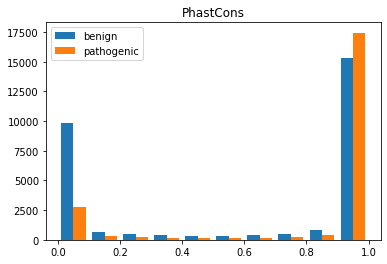

In [ ]:
#Extract phastCons data and append it to variants
phastcons_data = pyBigWig.open(parent_path + "/hg38.phastCons100way.bw")
missense_likely["phastCons"] = [phastcons_data.stats("chr" + x, y, y+1) for x, y in zip(missense_likely["CHROM"],missense_likely["POS"])]
missense_likely["phastCons"] = missense_likely["phastCons"].str[0]
#Plot a histogram
pathogenic = missense_likely[missense_likely['Class label']== 1]
benign = missense_likely[missense_likely['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['phastCons'], pathogenic['phastCons']], label=names)
plt.legend()
plt.title("PhastCons")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'O/E')

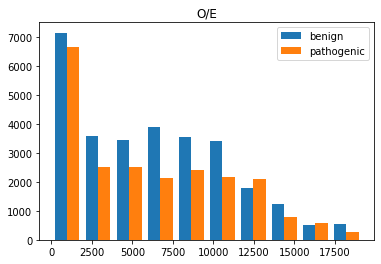

In [ ]:
#Extract gnomad data and append values to variants
gnomad_data = pd.read_csv(parent_path + '/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz', compression='gzip', sep='\t', quotechar='"')
gnomad_data = gnomad_data.loc[:, gnomad_data.columns.intersection(['gene','oe_lof_upper_rank', 'exac_pLI'])]
missense_likely = pd.merge(missense_likely, gnomad_data, left_on="GENE1", right_on="gene", how="left")
missense_likely["oe_lof_upper_rank"] = missense_likely["oe_lof_upper_rank"].replace(np.nan, missense_likely["oe_lof_upper_rank"].max()/2)
missense_likely["exac_pLI"] = missense_likely["exac_pLI"].replace(np.nan, missense_likely["exac_pLI"].max()/2)
missense_likely= missense_likely.rename(columns={'oe_lof_upper_rank': "first oe_lof_upper_rank"})
missense_likely= missense_likely.rename(columns={'exac_pLI': "first exac_pLI"})

missense_likely = pd.merge(missense_likely, gnomad_data, left_on="GENE2", right_on="gene", how="left")
missense_likely["oe_lof_upper_rank"] = missense_likely[missense_likely['GENE2'].values != None]["oe_lof_upper_rank"].replace(np.nan, missense_likely["oe_lof_upper_rank"].max()/2)
missense_likely["exac_pLI"] = missense_likely[missense_likely['GENE2'].values != None]["exac_pLI"].replace(np.nan, missense_likely["exac_pLI"].max()/2)
missense_likely= missense_likely.rename(columns={'oe_lof_upper_rank': "second oe_lof_upper_rank"})
missense_likely= missense_likely.rename(columns={'exac_pLI': "second exac_pLI"})
missense_likely["oe_lof_upper_rank"] =  missense_likely[["first oe_lof_upper_rank", "second oe_lof_upper_rank" ]].mean(axis=1)
missense_likely["exac_pLI"] =  missense_likely[["first exac_pLI", "second exac_pLI"]].mean(axis=1)

#Plot histograms
pathogenic = missense_likely[missense_likely['Class label']== 1]
benign = missense_likely[missense_likely['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign['oe_lof_upper_rank'], pathogenic['oe_lof_upper_rank']], label=names)
plt.legend()
plt.title("O/E")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'exac_pLI')

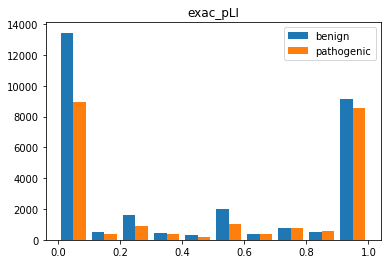

In [ ]:
#Plot histograms
pathogenic = missense_likely[missense_likely['Class label']== 1]
benign = missense_likely[missense_likely['Class label']== 0]
names = ['benign', 'pathogenic']
plt.hist([benign["exac_pLI"], pathogenic["exac_pLI"]], label=names)
plt.legend()
plt.title("exac_pLI")

In [ ]:
# from Xpresso dataset
# read by default 1st sheet of an excel file
dataframe1 = pd.read_excel(parent_path + "/xpresso.xlsx")
Xpresso = dataframe1[['Unnamed: 1', 'Unnamed: 63']][2:]
Xpresso = Xpresso.rename(columns={'Unnamed: 1':"Gene Name", 'Unnamed: 63':"Median expression" })[1:]
missense_likely = pd.merge(missense_likely, Xpresso, left_on="GENE1", right_on="Gene Name", how="left")
missense_likely["Median expression"] = missense_likely["Median expression"].replace(np.nan, 0)
missense_likely = missense_likely.rename(columns = {"Median expression": "median_expression_level_1"})

missense_likely = pd.merge(missense_likely, Xpresso, left_on="GENE2", right_on="Gene Name", how="left")
missense_likely["Median expression"] = missense_likely[missense_likely['GENE2'].values != None]["Median expression"].replace(np.nan, 0)
missense_likely = missense_likely.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
missense_likely["mean gene_expression_level"] =  missense_likely[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
missense_likely = missense_likely.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


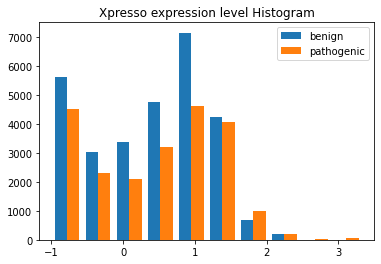

In [ ]:
plt.hist([missense_likely[missense_likely["Class label"] == 0 ]["mean gene_expression_level"],missense_likely[missense_likely["Class label"] == 1 ]["mean gene_expression_level"]], label = ["benign", "pathogenic"])  
plt.title('Xpresso expression level Histogram')


plt.legend(loc='upper right')

In [ ]:
new = missense_likely[["CHROM", "POS", "ID", "REF", "ALT"]]
# new = new.iloc[0:20]
new["ALT"] = new["ALT"].apply(lambda row: row[0])
header = """##fileformat=VCFv4.1
#CHROM POS ID REF ALT
"""

output_VCF = "missenselikely_data.vcf"
with open(output_VCF, 'w') as vcf:
    vcf.write(header)

new.to_csv(output_VCF, sep="\t", mode='a', index=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


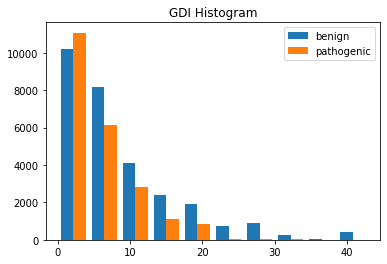

In [ ]:
import re
gdi_data = pd.read_csv(parent_path + "/GDI_full.txt",  delimiter="\t")
gdi_data = gdi_data[["Gene", "GDI-Phred"]]
gdi_data = gdi_data.rename(columns={"Gene": "Gene Name", "GDI-Phred":"Median expression"})


missense_likely = pd.merge(missense_likely, gdi_data, left_on="GENE1", right_on="Gene Name", how="left")
missense_likely["Median expression"] = missense_likely["Median expression"].replace(np.nan, missense_likely["Median expression"].max()/2)
missense_likely = missense_likely.rename(columns = {"Median expression": "median_expression_level_1"})

missense_likely = pd.merge(missense_likely, gdi_data, left_on="GENE2", right_on="Gene Name", how="left")
missense_likely["Median expression"] = missense_likely[missense_likely['GENE2'].values != None]["Median expression"].replace(np.nan, missense_likely["Median expression"].max()/2)
missense_likely = missense_likely.rename(columns = {"Median expression": "median_expression_level_2"})

#Take average of gene1 and gene2 expression values 
missense_likely["GDI"] =  missense_likely[["median_expression_level_1", "median_expression_level_2"]].mean(axis=1)
missense_likely = missense_likely.drop(columns = ["median_expression_level_1", "median_expression_level_2", "Gene Name_x", "Gene Name_y"])

plt.hist([missense_likely[missense_likely["Class label"] == 0 ]["GDI"],missense_likely[missense_likely["Class label"] == 1 ]["GDI"]], label = ["benign", "pathogenic"])  
plt.title('GDI Histogram')


plt.legend(loc='upper right')

In [ ]:
print("Pathogenic/likely-pathogenic count: " + np.str(np.count_nonzero(missense_likely["Class label"])))

Pathogenic/likely-pathogenic count: 22110


In [ ]:
print("Benign/likely-benign count: " + np.str(len(missense_likely["Class label"]) - np.count_nonzero(missense_likely["Class label"])))

Benign/likely-benign count: 29096


In [ ]:
import gzip
with gzip.open(parent_path +'/caad2.tsv.gz', 'rt') as f:
  # with gzip.open('chr22_subsampled_snps.vcf.gz', 'rt') as f:
  lines = f.readlines()
  with open('caddunzipped2.txt', 'w') as t:
    for line in lines[1:]:
        t.write(line)
        t.write('\n')
cadd_data = pd.read_csv('caddunzipped2.txt', delimiter="\t")
cadd_data = cadd_data.rename(columns={"PHRED": "CADD_score"})
cadd_data = cadd_data.drop_duplicates(
  subset = ['#Chrom', 'Pos'],
  keep = 'last').reset_index(drop = True)
cadd_data["#Chrom"] = cadd_data["#Chrom"].apply(lambda r:str(r))

cadd_data = cadd_data.drop_duplicates(
  subset = ['#Chrom', 'Pos'],
  keep = 'last').reset_index(drop = True)
cadd_data["#Chrom"] = cadd_data["#Chrom"].apply(lambda r:str(r))

cadd_columns = ["CADD_score", "Grantham", "PolyPhenVal" ,"SIFTval"]
cadd_data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,129) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#Chrom,Pos,Ref,Alt,Type,Length,AnnoType,Consequence,ConsScore,ConsDetail,GC,CpG,motifECount,motifEName,motifEHIPos,motifEScoreChng,oAA,nAA,GeneID,FeatureID,GeneName,CCDS,Intron,Exon,cDNApos,relcDNApos,CDSpos,relCDSpos,protPos,relProtPos,Domain,Dst2Splice,Dst2SplType,minDistTSS,minDistTSE,SIFTcat,SIFTval,PolyPhenCat,PolyPhenVal,priPhCons,...,EncodeH3K27me3-max,EncodeH3K36me3-sum,EncodeH3K36me3-max,EncodeH3K79me2-sum,EncodeH3K79me2-max,EncodeH4K20me1-sum,EncodeH4K20me1-max,EncodeH2AFZ-sum,EncodeH2AFZ-max,EncodeDNase-sum,EncodeDNase-max,EncodetotalRNA-sum,EncodetotalRNA-max,Grantham,SpliceAI-acc-gain,SpliceAI-acc-loss,SpliceAI-don-gain,SpliceAI-don-loss,MMSp_acceptorIntron,MMSp_acceptor,MMSp_exon,MMSp_donor,MMSp_donorIntron,Dist2Mutation,Freq100bp,Rare100bp,Sngl100bp,Freq1000bp,Rare1000bp,Sngl1000bp,Freq10000bp,Rare10000bp,Sngl10000bp,EnsembleRegulatoryFeature,dbscSNV-ada_score,dbscSNV-rf_score,RemapOverlapTF,RemapOverlapCL,RawScore,CADD_score
0,1,930245,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.662,0.133,NaN,NaN,NaN,NaN,D,N,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,246.0,0.096,163.0,0.080,55.0,0.081,lcompl,NaN,NaN,68,5549,deleterious,0.00,possibly_damaging,0.468,0.063,...,3.51,8.32,1.89,5.45,2.06,12.07,2.80,8.73,2.81,0.65,0.18,0.57,0.21,23.0,0.00,0.00,0.0,0.0,0.0,0.0,-0.070,0.0,0.0,3.0,0.0,4.0,22.0,1.0,17.0,200.0,40.0,114.0,1974.0,NaN,NaN,NaN,12.0,17.0,3.267428,24.000
1,1,930248,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.656,0.147,NaN,NaN,NaN,NaN,G,S,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,249.0,0.098,166.0,0.081,56.0,0.082,lcompl,NaN,NaN,65,5546,deleterious,0.01,benign,0.014,0.073,...,3.47,8.32,1.89,5.45,2.06,11.57,2.80,8.73,2.81,0.57,0.17,0.56,0.20,56.0,0.00,0.00,0.0,0.0,0.0,0.0,-0.180,0.0,0.0,6.0,0.0,4.0,21.0,1.0,17.0,198.0,40.0,114.0,1974.0,NaN,NaN,NaN,12.0,17.0,2.363380,21.900
2,1,930282,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.623,0.120,NaN,NaN,NaN,NaN,R,Q,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,283.0,0.111,200.0,0.098,67.0,0.098,hmmpanther,NaN,NaN,31,5512,tolerated,1.00,benign,0.001,0.036,...,4.63,9.82,4.72,7.09,2.00,16.99,3.29,10.21,4.03,0.60,0.14,0.52,0.26,43.0,0.00,0.00,0.0,0.0,0.0,0.0,-0.035,0.0,0.0,9.0,0.0,6.0,28.0,1.0,16.0,199.0,42.0,115.0,1982.0,NaN,NaN,NaN,13.0,18.0,-0.066612,0.973
3,1,930320,C,T,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.636,0.107,NaN,NaN,NaN,NaN,R,C,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,3/14,321.0,0.126,238.0,0.116,80.0,0.117,hmmpanther,17.0,DONOR,8,5474,deleterious,0.05,benign,0.332,0.656,...,6.84,8.85,4.32,8.25,3.60,17.78,3.80,11.69,4.03,0.59,0.22,0.71,0.47,180.0,0.00,0.00,0.0,0.0,0.0,0.0,-0.070,0.0,0.0,3.0,0.0,5.0,30.0,1.0,16.0,206.0,41.0,114.0,1974.0,NaN,NaN,NaN,13.0,18.0,3.041162,23.500
4,1,931058,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,missense,0.623,0.080,NaN,NaN,NaN,NaN,V,M,ENSG00000187634,ENST00000342066,SAMD11,CCDS2.2,NaN,4/14,357.0,0.140,274.0,0.134,92.0,0.135,hmmpanther,20.0,ACCEPTOR,746,4736,deleterious,0.00,benign,0.165,0.739,...,5.60,4.63,2.88,5.68,2.98,16.15,3.98,3.91,0.90,0.63,0.14,0.96,0.72,21.0,0.00,0.05,0.0,0.0,0.0,0.0,-0.164,0.0,0.0,7.0,0.0,1.0,22.0,2.0,9.0,189.0,40.0,120.0,1984.0,NaN,NaN,NaN,10.0,11.0,2.193709,20.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49827,X,155524537,G,A,SNV,0,Transcript,INTRONIC,2,"intron,non_coding",0.503,0.093,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000224533,ENST00000452506,TMLHE-AS1,NaN,1/1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20741,266,NaN,NaN,NaN,NaN,0.510,...,2.08,63.43,10.87,10.67,1.76,10.42,2.40,7.32,2.41,0.28,0.09,6.03,1.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,17.0,2.0,1.0,105.0,9.0,25.0,680.0,NaN,NaN,NaN,4.0,4.0,3.501734,24.700
49828,X,155

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

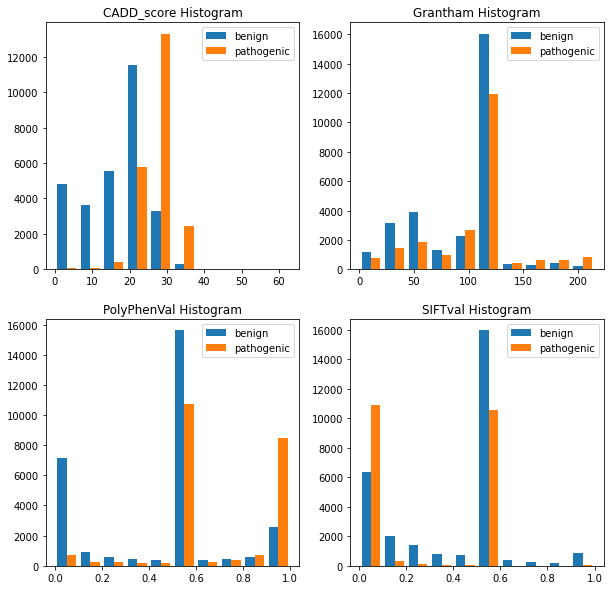

In [ ]:
cadd_columns = ["CADD_score", "Grantham", "PolyPhenVal" ,"SIFTval"]
cadd_data = cadd_data[["#Chrom", "Pos"]+cadd_columns]
cadd_missense_likely_merged = pd.merge(left = missense_likely, right = cadd_data, left_on = ["CHROM", "POS"], right_on=["#Chrom", "Pos"],how="left")
for col in cadd_columns:
  cadd_missense_likely_merged[col] = cadd_missense_likely_merged[col].replace(np.nan, cadd_missense_likely_merged[col].max()/2) 

missense_likely = cadd_missense_likely_merged.drop(columns =["#Chrom", "Pos"])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(2):
    for j in range(2):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(cadd_columns):
            col = cadd_columns[counter]


            ax.hist([missense_likely[missense_likely["Class label"] == 0 ][col],missense_likely[missense_likely["Class label"] == 1 ][col]], label = ["benign", "pathogenic"])  
            ax.set_title(col + " Histogram")
            ax.legend(loc='upper right')

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

In [ ]:
missense_likely.columns
c =["CHROM", "POS", "Class label", "mean RVIS score", "phastCons", "oe_lof_upper_rank", "exac_pLI", "GDI", "CADD_score", "Grantham", "PolyPhenVal", "SIFTval"]
for val in c:
  if val not in missense_likely.columns:
    print(val)
missense_likely_data = missense_likely[c]

training_set, validation_set= train_test_split(missense_likely_data, test_size=0.2)
X_train = training_set.drop(columns=["Class label", "CHROM", "POS"])
Y_train = training_set.loc[:, training_set.columns.intersection(['Class label'])]
X_test = validation_set.drop(columns=["Class label", "CHROM", "POS"])
Y_test = validation_set.loc[:, validation_set.columns.intersection(['Class label'])]
accuracy_score(model.predict(X_test), Y_test)

0.8463190783050185

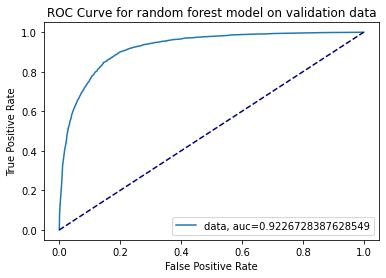

In [ ]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color="navy",linestyle="--")
plt.title("ROC Curve for random forest model on validation data")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()